In [125]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
import seaborn as sns

# Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class Feeder():
    
    def __init__(self, X, Y, length=6, batchsize=64):
        self.X = X
        self.Y = Y
        self.n = X.shape[0]
        self.length = length
        self.batchsize = batchsize 
        
    def next(self):
        ret = []
        labels = []
        for i in range(self.batchsize):
            temp = []
            temp2 = []
            for j in range(self.length):
                index = np.random.randint(self.n)
                temp.append(X[index])
                temp2.append(np.argmax(Y[index]))
            ret.append(np.concatenate(temp, axis=1))
            labels.append(temp2)
        ret = np.stack(ret, axis=0)
        labels = np.array(labels)
        return ret, labels

In [4]:
data = Feeder(X, Y)
x, labels = data.next()

[6 5 4 7 0 5]
(28, 168)


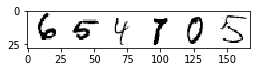

In [5]:
plt.figure(figsize=(4, 24))
plt.imshow(x[0], cmap='Greys')
print labels[0]
print x[0].shape
plt.show()

# Model (recurrent VAE)

In [180]:
class VRNN():
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Core parameters
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Tracking data
        self.learning_curve = []
        self.record = {"x_":[], "latent_mu":[], "prior_mu":[], "y":[], "x":[]}
        
        # Model specific parameters
        self.lr = 0.001
        self.batchsize = 64
        self.dim_latent= 2
        self.input_shape = [28, 168]
        self.memory = 32
        
        # Building the graph
        self.ops = self.__build()
        self.sesh.run(tf.global_variables_initializer())
    
    def __build(self):
        
        if self.built:
            return -1
        else:
            self.built = True
            
        #########
        # MODEL #
        #########
        
        # Some placeholders to define inputs/parameters
        x = tf.placeholder(tf.float32, shape=[self.batchsize]+self.input_shape, name="x")
        print x
        
        # Defining LSTM cells to be used as encoder/decoder 
        # Change this to have other kinds of reccurent cells.
        self.encoder = tf.contrib.rnn.LSTMCell(self.memory, state_is_tuple=True, activation=tf.nn.elu)
        self.decoder = tf.contrib.rnn.LSTMCell(self.memory, state_is_tuple=True, activation=tf.nn.elu)
        
        # Some initialization on states and inputs
        dec_output = tf.zeros((self.batchsize, self.memory))
        enc_state = self.encoder.zero_state(self.batchsize, tf.float32)
        dec_state = self.decoder.zero_state(self.batchsize, tf.float32)
        
        # Some lists to keep track of output and latent tensors
        canvases = []
        mus = [] # keeps tracks of mus of latent distributions
        logsigmas = [] # keeps tracks of log(sigmas) of latent distributions
        
        reuse = None
        
        # Unrollinng the whole graph
        for i in range(self.input_shape[-1]):
            
            # _input = tf.concat([x[:, :, i], dec_output], axis=1)
            _input = x[:, :, i]
            
            # Apply an encoder to it using appropriate reuse term
            enc_output, enc_state = self.encode(_input, enc_state, reuse=reuse)
            
            # Sampling 
            with tf.variable_scope("sampling", reuse=reuse):
                z_mean = tf.contrib.slim.fully_connected(enc_output, self.dim_latent, activation_fn=tf.identity, scope="mean")
                z_logsigma = tf.contrib.slim.fully_connected(enc_output, self.dim_latent, activation_fn=tf.identity, scope="sigma")
                mus.append(z_mean)
                logsigmas.append(z_logsigma)
            
            z = self.sample(z_mean, z_logsigma)
            
            # Apply an decoder to latent values.
            dec_output, dec_state = self.decode(z, dec_state, reuse=reuse)
            
            output = tf.contrib.slim.fully_connected(dec_output, self.input_shape[0],\
                                                                       activation_fn=tf.sigmoid,\
                                                                       scope="writing",\
                                                                       reuse=reuse)
            
            # Add to canvas
            canvases.append(output) 
            
            # Keep reusing the first weights built.
            reuse = True
            
        reconstructed = tf.stack(canvases, axis=-1)
        print reconstructed
            
        ########
        # LOSS #
        ########
        
        # Defining reconstruction loss
        reconstruction_loss = self.binaryXent(reconstructed, x)
        print reconstruction_loss
        
        kl_holder = []
        # Defining KL loss
        for i in range(self.input_shape[-1]):
            kl_holder.append(self.kld(mus[i], logsigmas[i]))
        kl_holder = tf.stack(kl_holder, -1)
        print kl_holder
        kl_divergence = tf.reduce_mean(kl_holder, -1)
        
        with tf.name_scope("cost"):
            # average over minibatch
            cost = tf.reduce_mean(reconstruction_loss + kl_divergence, name="draw_cost")
            
        ################
        # OPTIMIZATION #
        ################
        
        # Defining optimization procedure.
        with tf.name_scope("Adam_optimizer"):
            optimizer = tf.train.AdamOptimizer()
            tvars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, tvars)
            # Gradient clipping here.
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train = optimizer.apply_gradients(clipped, name="minimize_cost")
            
        mus = tf.stack(mus, -1)
        
        return dict(
            x=x,
            cost=cost,
            kld_loss=kl_divergence,
            rec_loss=reconstruction_loss,
            reconstruction=reconstructed,
            prior_mu = mus,
            latent_mu = mus,
            train=train
        )
    
    # training procedure.
    def train(self, X, epochs):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batchsize))
        
        e = 0
        start_e = e
        while e < epochs:
            epoch_cost = {"kld":[],
                          "rec":[],
                          "cost":[]}
            
            if e == epochs-1: self.latent_record = {"z":[],
                                                    "y":[]}
            
            for i in range(batch_num):
                #Training happens here.
                batch = X.next()
                feed_dict = {self.ops["x"]: batch[0]}
                ops_to_run = [self.ops["reconstruction"],
                              self.ops["cost"],
                              self.ops["kld_loss"],
                              self.ops["rec_loss"],
                              self.ops["latent_mu"],
                              self.ops["prior_mu"],
                              self.ops["train"]]
                
                reconstruction, cost, kld, rec, lmu, pmu, _= self.sesh.run(ops_to_run,
                                                                           feed_dict)
                
                # Record necessary data
                if e == epochs-1: self.record["x_"] = self.record["x_"] + [_ for _ in reconstruction]
                if e == epochs-1: self.record["x"] = self.record["x"] + [_ for _ in batch[0]]
                if e == epochs-1: self.record["y"] = self.record["y"] + [_ for _ in batch[1]]
                if e == epochs-1: self.record["latent_mu"] = self.record["latent_mu"] + [_ for _ in lmu]
                if e == epochs-1: self.record["prior_mu"] = self.record["prior_mu"] + [_ for _ in pmu]
                
                # Record error terms
                epoch_cost["kld"].append(np.mean(kld))
                epoch_cost["rec"].append(np.mean(rec))
                epoch_cost["cost"].append(cost)
                
                sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f, kld: %.2f, rec: %.2f"
                                         %(self.e, start_e+epochs, cost, np.mean(kld), np.mean(rec)))
            
            #Record statistics
            self.e+=1
            e+= 1
            self.learning_curve.append(epoch_cost)
            
    # KLD for latent regularization   
    def kld(self, mu_p, sigma_p, mu_q=None, sigma_q=None, offset=1e-7):
        if mu_q == None: mu_q=tf.zeros((self.batchsize, 2))
        if sigma_q == None: sigma_q = tf.ones((self.batchsize, 2))
        with tf.variable_scope("KLD"):
            sigma_p_ = tf.maximum(offset, sigma_p)
            sigma_q_ = tf.maximum(offset, sigma_q)
            return tf.reduce_sum(0.5*(2*tf.log(sigma_q_)-2*tf.log(sigma_p_)
                                      +(tf.square(sigma_p_)+tf.square(mu_p-mu_q))/tf.square(sigma_q_)-1), -1)
    
    # Binary crossentropy loss for reconstruction error.
    def binaryXent(self, pred, y, offset=1e-7):
        with tf.variable_scope("BinearyXent"):
            obs_ = tf.clip_by_value(pred, offset, 1 - offset)
            return -tf.reduce_sum(y * tf.log(obs_) + (1 - y) * tf.log(1 - obs_), [-1, -2])

    # Defines a encoder graph
    def encode(self, _input, state, reuse=None):
        with tf.variable_scope("encoder", reuse = reuse):
            # state_is_tuple shouldnt be necessary if you are using modern tensorflow modules.
            return self.encoder(_input, state)
        
    # Defines a decoder graph
    def decode(self, _input, state, reuse=None):
        with tf.variable_scope("decoder", reuse = reuse):
            return self.decoder(_input, state)
        
    # ReparameterizationTrick
    def sample(self, mu, log_sigma):
        with tf.name_scope("sample_reparam"):
            epsilon = tf.random_normal(tf.shape(log_sigma), name="0mean1varGaus")
            return mu + epsilon * tf.exp(log_sigma)


In [181]:
model = VRNN()

Tensor("x:0", shape=(64, 28, 168), dtype=float32)
Tensor("stack:0", shape=(64, 28, 168), dtype=float32)
Tensor("BinearyXent/Neg:0", shape=(64,), dtype=float32)
Tensor("stack_1:0", shape=(64, 168), dtype=float32)


In [182]:
model.train(data, 10)

Epoch: [ 9/10] loss: 600.94, kld: 28.97, rec: 571.9717.15

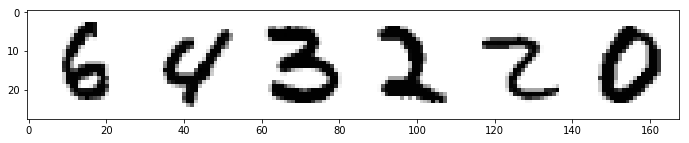

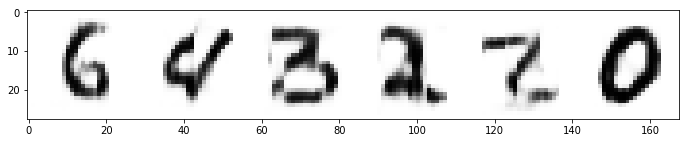

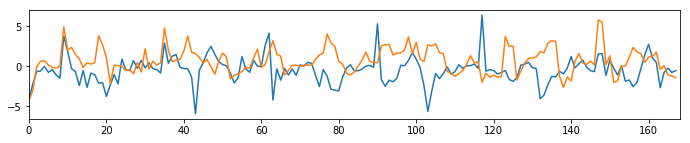

In [327]:
index = np.random.randint(1000)

x = model.record["x"][-1*index]
plt.figure(figsize=(12, 2))
plt.imshow(x, cmap='Greys')
plt.show()

x_ = model.record["x_"][-1*index]
plt.figure(figsize=(12, 2))
plt.imshow(x_, cmap='Greys')
plt.show()

mus = model.record["latent_mu"][-1*index]
plt.figure(figsize=(11.66, 2))
plt.plot(mus[0])
plt.plot(mus[1])
plt.xlim(0, 168)
plt.show()

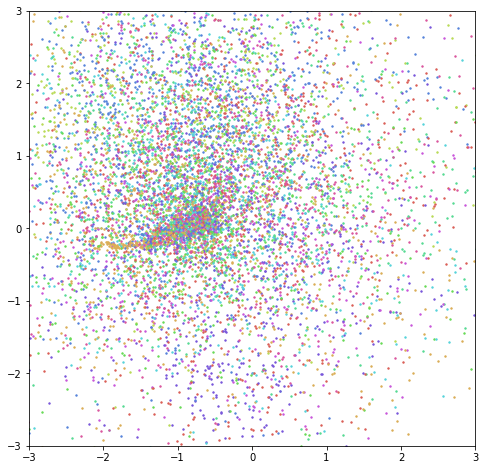

In [324]:
colors = sns.color_palette("hls", 10)

plt.figure(figsize=(8, 8))
for i in range(-100, -1, 1):
    mu = model.record["latent_mu"][i]
    y = model.record["y"][i]
    for j in range(6):
        plt.scatter(mu[0, j*28+5:(j+1)*28-5], mu[1, j*28+5:(j+1)*28-5], c=colors[y[j]], s=2)
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.show()

In [133]:
len(mus)

110080